In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install "pandas<2.0.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 19.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.3 which is incompatible.


In [4]:

import re
import ast
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

In [5]:
# brendanho123
# data_path = 'drive/My Drive/Colab Notebooks/W266/Final Project/data'

# chris
data_path = '/content/drive/MyDrive/Final Project/data'

# Animes

In [6]:
animes_df = pd.read_csv(f'{data_path}/raw_data/animes.csv')
animes_df.head(5)

,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/766...,https://myanimelist.net/anime/28891/Haikyuu_Se...
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,https://cdn.myanimelist.net/images/anime/3/671...,https://myanimelist.net/anime/23273/Shigatsu_w...
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83,https://cdn.myanimelist.net/images/anime/6/867...,https://myanimelist.net/anime/34599/Made_in_Abyss
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://cdn.myanimelist.net/images/anime/1223/...,https://myanimelist.net/anime/5114/Fullmetal_A...
4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']","Jan 6, 2017",1.0,214621,502,22.0,8.83,https://cdn.myanimelist.net/images/anime/3/815...,https://myanimelist.net/anime/31758/Kizumonoga...


In [7]:
animes_df.columns

Index(['uid', 'title', 'synopsis', 'genre', 'aired', 'episodes', 'members',
       'popularity', 'ranked', 'score', 'img_url', 'link'],
      dtype='object')

### Preproces

In [8]:
# Remove duplicated rows
print("Inital df length:", len(animes_df))


duplicate_count = animes_df.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)


animes_df = animes_df.drop_duplicates()
print("Remove duplicates df length:", len(animes_df))

Inital df length: 19311
Number of duplicate rows: 2943
Remove duplicates df length: 16368


In [9]:
# Remove rows with duplicate uids
# The only columns with mismatched values are members, popularity and ranked
# We keep rows with higher members and popularity but lower ranked

print("Inital df length:", len(animes_df))
uid_value_counts = animes_df['uid'].value_counts()

duplicate_uid = uid_value_counts[uid_value_counts > 1].index
print("Number of duplicate rows:", len(duplicate_uid))

dup_column_set = set()
for uid in duplicate_uid:
  uid_df = animes_df[animes_df['uid'] == uid]
  row1 = uid_df.iloc[0]
  row2 = uid_df.iloc[1]

  columns_not_equal = row1.index[(row1 != row2) & (~(row1.isnull() & row2.isnull()))].tolist()
  dup_column_set.update(columns_not_equal)

  drop_index = set()
  if 'members' in columns_not_equal:
    if row1['members'] > row2['members']:
      drop_index.add(row2.name)
    else:
      drop_index.add(row1.name)
  elif 'popularity' in columns_not_equal:
    if row1['popularity'] > row2['popularity']:
      drop_index.add(row2.name)
    else:
      drop_index.add(row1.name)
  elif 'ranked' in columns_not_equal:
    if row1['ranked'] < row2['ranked']:
      drop_index.add(row2.name)
    else:
      drop_index.add(row1.name)


  if len(drop_index) == 1:
    animes_df = animes_df.drop(drop_index)
  else:
    print(uid_df[columns_not_equal])


print("Remove duplicates df length:", len(animes_df))


Inital df length: 16368
Number of duplicate rows: 152
Remove duplicates df length: 16216


### Synopsis

In [10]:
# Average legnth is ~394 words
# Min length is 1 and max length is 2753

synopsis_len = animes_df['synopsis'].str.len()
synopsis_len.describe()

count    15453.000000
mean       393.919239
std        343.132851
min          1.000000
25%        108.000000
50%        299.000000
75%        587.000000
max       2753.000000
Name: synopsis, dtype: float64

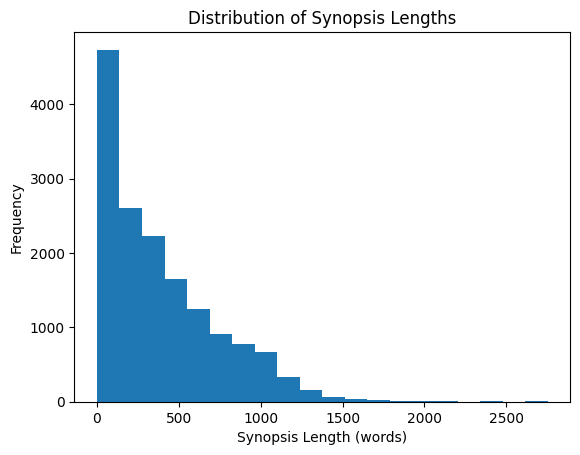

In [11]:
# Create a histogram of the synopsis lengths

plt.hist(synopsis_len, bins=20)
plt.xlabel('Synopsis Length (words)')
plt.ylabel('Frequency')
plt.title('Distribution of Synopsis Lengths')
plt.show()


### Genre

In [12]:
all_genres = set()
for genre in animes_df['genre']:
  genres = genre.replace('[','').replace(']','').replace("'", "").split(', ')
  all_genres.update(genres)

all_genres

{'',
 'Action',
 'Adventure',
 'Cars',
 'Comedy',
 'Dementia',
 'Demons',
 'Drama',
 'Ecchi',
 'Fantasy',
 'Game',
 'Harem',
 'Hentai',
 'Historical',
 'Horror',
 'Josei',
 'Kids',
 'Magic',
 'Martial Arts',
 'Mecha',
 'Military',
 'Music',
 'Mystery',
 'Parody',
 'Police',
 'Psychological',
 'Romance',
 'Samurai',
 'School',
 'Sci-Fi',
 'Seinen',
 'Shoujo',
 'Shoujo Ai',
 'Shounen',
 'Shounen Ai',
 'Slice of Life',
 'Space',
 'Sports',
 'Super Power',
 'Supernatural',
 'Thriller',
 'Vampire',
 'Yaoi',
 'Yuri'}

In [13]:
# One hot encode genres

def clean_genre(genre_str):
    return genre_str.replace('[','').replace(']','').replace("'", "")

animes_df['genre_cleaned'] = animes_df['genre'].apply(clean_genre).str.split(', ')
animes_df.drop(columns= 'genre')

genres_encoded = pd.get_dummies(animes_df['genre_cleaned'].apply(pd.Series).stack()).sum(level=0)


animes_df_encoded = pd.concat([animes_df, genres_encoded], axis=1).drop(['genre', 'genre_cleaned', ''], axis=1)
animes_df_encoded.head(5)

<ipython-input-13-eb4c82329a73>:9: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  genres_encoded = pd.get_dummies(animes_df['genre_cleaned'].apply(pd.Series).stack()).sum(level=0)


,uid,title,synopsis,aired,episodes,members,popularity,ranked,score,img_url,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/766...,...,0,0,0,1,0,0,0,0,0,0
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,https://cdn.myanimelist.net/images/anime/3/671...,...,0,0,0,0,0,0,0,0,0,0
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83,https://cdn.myanimelist.net/images/anime/6/867...,...,0,0,0,0,0,0,0,0,0,0
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://cdn.myanimelist.net/images/anime/1223/...,...,0,0,0,0,0,0,0,0,0,0
4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"Jan 6, 2017",1.0,214621,502,22.0,8.83,https://cdn.myanimelist.net/images/anime/3/815...,...,0,0,0,0,0,1,0,1,0,0


### Aired

In [14]:
# Deprecated

# def extract_date_components(date_str):
#     month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

#     components = date_str.replace(',','').split()
#     year = None
#     month = None
#     day = None

#     for component in components:
#         if component in month_names:
#             month = month_names.index(component) + 1
#         elif len(component) == 4:
#             year = int(component)
#         elif len(component) < 3:
#             day = int(component)
#         else:
#             raise ValueError("Invalid date format")

#     # print(date_str)
#     # print(year, month, day)

#     return year, month, day


# def extract_date_range(date_str):
#     aired_date, end_date = date_str.split(' to ')

#     start_year, start_month, start_day = extract_date_components(aired_date)
#     if end_date == '?':
#         end_year = None
#         end_month = None
#         end_day = None
#     else:
#         end_year, end_month, end_day = extract_date_components(end_date)


#     return start_year, start_month, start_day, end_year, end_month, end_day

# def extract_dates(date_str):
#     # print(date_str)
#     start_year, start_month, start_day, end_year, end_month, end_day = None, None, None, None, None, None
#     if date_str.lower() == 'not available':
#         start_year, start_month, start_day, end_year, end_month, end_day = None, None, None, None, None, None
#     elif 'to' in date_str:
#         start_year, start_month, start_day, end_year, end_month, end_day = extract_date_range(date_str)
#     else:
#         start_year, start_month, start_day = extract_date_components(date_str)

#     return pd.Series([start_year, start_month, start_day, end_year, end_month, end_day], index=['start_year', 'start_month', 'start_day', 'end_year', 'end_month', 'end_day'])


In [18]:
def extract_date_epoch(date_str):
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    components = date_str.replace(',','').split()
    year = None
    month = None
    day = None

    for component in components:
        if component in month_names:
            month = component
        elif len(component) == 4:
            year = component
        elif len(component) < 3:
            day = component
        else:
            raise ValueError("Invalid date format")
    if not month:
        month = 'Jan'
    if not day:
        day = '1'

    try:
        date_obj = datetime.strptime(f'{month} {day}, {year}', '%b %d, %Y')
    except ValueError:
        print(f'ERROR: incorrect format {date_str}')

    epoch_time = int(date_obj.timestamp())

    return epoch_time

def extract_date_range(date_str):
    aired_start_date, aired_end_date = date_str.split(' to ')

    aired_start_epoch = extract_date_epoch(aired_start_date)
    if aired_end_date == '?':
        aired_end_epoch = None
    else:
        aired_end_epoch = extract_date_epoch(aired_end_date)

    return aired_start_epoch, aired_end_epoch

def extract_dates(date_str):
  start, end = None, None
  if date_str.lower() == 'not available':
    start, end = None, None
  elif 'to' in date_str:
    start, end = extract_date_range(date_str)
  else:
    start, end = extract_date_epoch(date_str), None
  return pd.Series([start, end], index=['aired_start_epoch', 'aired_end_epoch'])

animes_df_encoded[['aired_start_epoch', 'aired_end_epoch']] = animes_df_encoded['aired'].apply(extract_dates)
animes_df_encoded['anime_age'] = np.round((int(time.time()) - animes_df_encoded['aired_start_epoch']) / (60 * 60 * 24 * 365.25)) # approximate second in a year
animes_df_encoded.head(5)


,uid,title,synopsis,aired,episodes,members,popularity,ranked,score,img_url,...,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri,aired_start_epoch,aired_end_epoch,anime_age
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/766...,...,1,0,0,0,0,0,0,1.443917e+09,1.459037e+09,9.0
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,https://cdn.myanimelist.net/images/anime/3/671...,...,0,0,0,0,0,0,0,1.412899e+09,1.426810e+09,9.0
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83,https://cdn.myanimelist.net/images/anime/6/867...,...,0,0,0,0,0,0,0,1.499386e+09,1.506643e+09,7.0
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://cdn.myanimelist.net/images/anime/1223/...,...,0,0,0,0,0,0,0,1.238890e+09,1.278202e+09,15.0
4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"Jan 6, 2017",1.0,214621,502,22.0,8.83,https://cdn.myanimelist.net/images/anime/3/815...,...,0,0,1,0,1,0,0,1.483661e+09,NaN,7.0


In [44]:
animes_df_encoded['aired_start_datetime'] = pd.to_datetime(animes_df_encoded['aired_start_epoch'], unit='s')
animes_df_encoded.head()
animes_df_encoded['aired_start_year'] = animes_df_encoded['aired_start_datetime'].dt.year

# # # Create decade buckets
decade_bins = range(1910, 2040, 10)  # Decade bins from 1910 to 2020
decade_labels = [f"{decade}s" for decade in decade_bins[:-1]]  # Labels for decades

# Bin years into decades
animes_df_encoded['aired_start_decade'] = pd.cut(animes_df_encoded['aired_start_year'], bins=decade_bins, labels=decade_labels, right=False)

# One-hot encode decades
decade_encoded = pd.get_dummies(animes_df_encoded['aired_start_decade'])
animes_df_decade_encoded = pd.concat([animes_df_encoded, decade_encoded], axis=1)
animes_df_decade_encoded.head()

/usr/local/lib/python3.10/dist-packages/pandas/core/tools/datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


,uid,title,synopsis,aired,episodes,members,popularity,ranked,score,img_url,...,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s,2020s
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/766...,...,0,0,0,0,0,0,0,0,1,0
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,https://cdn.myanimelist.net/images/anime/3/671...,...,0,0,0,0,0,0,0,0,1,0
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83,https://cdn.myanimelist.net/images/anime/6/867...,...,0,0,0,0,0,0,0,0,1,0
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://cdn.myanimelist.net/images/anime/1223/...,...,0,0,0,0,0,0,0,1,0,0
4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"Jan 6, 2017",1.0,214621,502,22.0,8.83,https://cdn.myanimelist.net/images/anime/3/815...,...,0,0,0,0,0,0,0,0,1,0


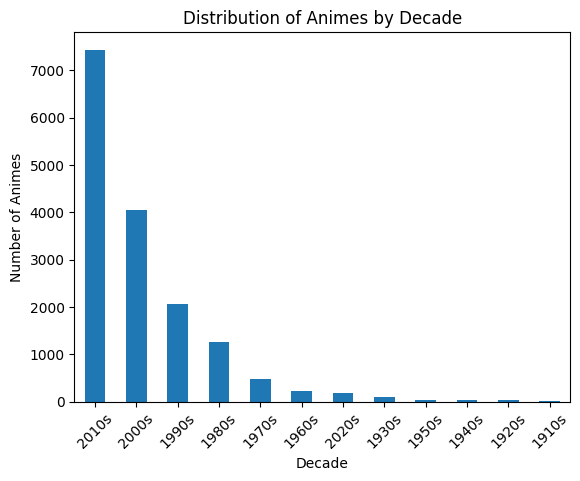

In [45]:
# prompt: histogram of animes_df_decade_encoded counts

import matplotlib.pyplot as plt
# Create a histogram of anime counts by decade
animes_df_decade_encoded['aired_start_decade'].value_counts().plot(kind='bar')
plt.xlabel('Decade')
plt.ylabel('Number of Animes')
plt.title('Distribution of Animes by Decade')
plt.xticks(rotation=45)
plt.show()


### Episodes

In [46]:
animes_df['episodes'].describe()

count    15724.000000
mean        11.657975
std         48.973125
min          1.000000
25%          1.000000
50%          2.000000
75%         12.000000
max       3057.000000
Name: episodes, dtype: float64

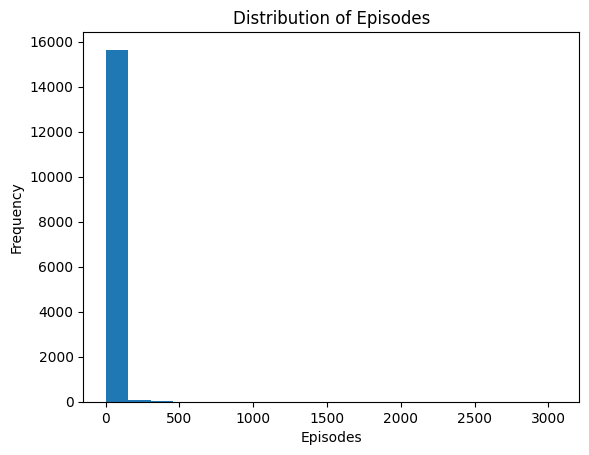

In [48]:
# Create a histogram of the synopsis lengths

plt.hist(animes_df['episodes'], bins=20)
plt.xlabel('Episodes')
plt.ylabel('Frequency')
plt.title('Distribution of Episodes')
plt.show()

## Members

In [49]:
animes_df['members'].describe()

count    1.621600e+04
mean     2.759190e+04
std      9.388251e+04
min      2.500000e+01
25%      2.920000e+02
50%      1.839500e+03
75%      1.160000e+04
max      1.871043e+06
Name: members, dtype: float64

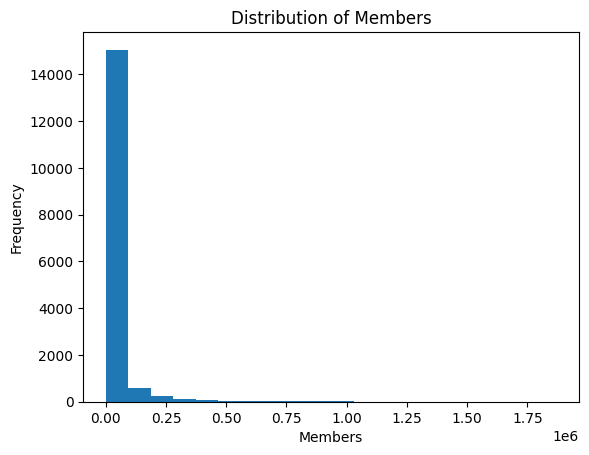

In [50]:
# Create a histogram of the synopsis lengths

plt.hist(animes_df['members'], bins=20)
plt.xlabel('Members')
plt.ylabel('Frequency')
plt.title('Distribution of Members')
plt.show()

## Popularity

In [51]:
# Inverse measure of members

animes_df['popularity'].describe()

# animes_df[animes_df['popularity'] == 0

count    16216.000000
mean      8161.172731
std       4714.318384
min          1.000000
25%       4082.000000
50%       8158.500000
75%      12243.250000
max      16338.000000
Name: popularity, dtype: float64

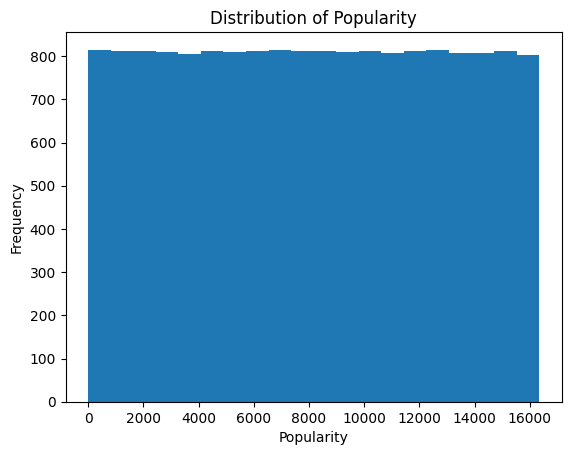

In [52]:
# Create a histogram of the synopsis lengths

plt.hist(animes_df['popularity'], bins=20)
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.title('Distribution of Popularity')
plt.show()

## Ranked

In [53]:
animes_df['ranked'].describe()

# animes_df[animes_df['ranked'] == 3]

count    14553.000000
mean      7332.376555
std       4235.757257
min          1.000000
25%       3659.000000
50%       7337.000000
75%      10993.000000
max      14675.000000
Name: ranked, dtype: float64

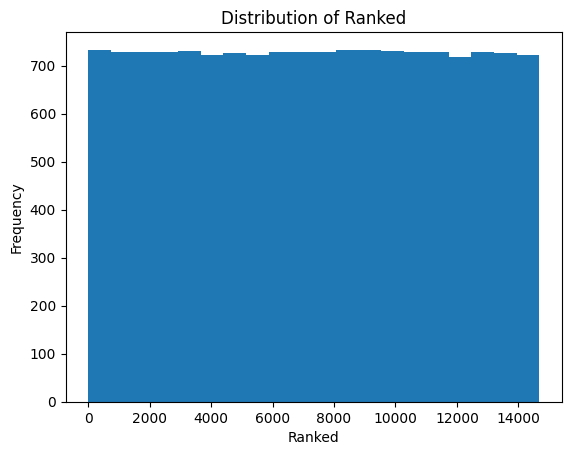

In [54]:
# Create a histogram of the synopsis lengths

plt.hist(animes_df['ranked'], bins=20)
plt.xlabel('Ranked')
plt.ylabel('Frequency')
plt.title('Distribution of Ranked')
plt.show()

## Score

In [55]:
animes_df['score'].describe()

# animes_df[animes_df['ranked'] == 3]

count    15875.000000
mean         6.346466
std          0.972700
min          1.250000
25%          5.700000
50%          6.370000
75%          7.040000
max          9.230000
Name: score, dtype: float64

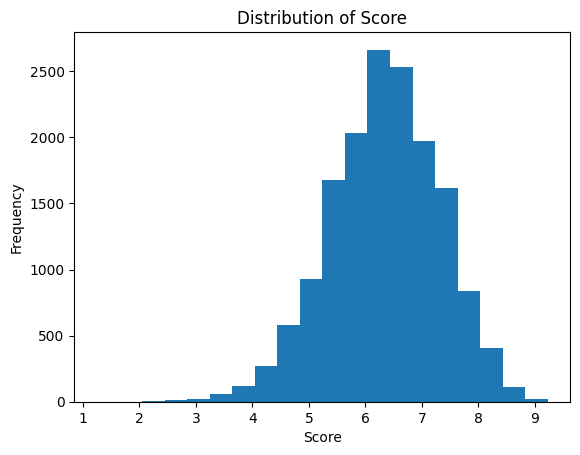

In [56]:
# Create a histogram of the synopsis lengths

plt.hist(animes_df['score'], bins=20)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Score')
plt.show()

## Save preprocessed df

In [61]:
final_animes_df = animes_df_decade_encoded.drop(columns=['img_url', 'link', 'aired', 'aired_start_year', 'aired_start_decade'])

final_animes_df.to_csv(f'{data_path}/raw_data/animes_final.csv', index=False)
final_animes_df.head()

,uid,title,synopsis,episodes,members,popularity,ranked,score,Action,Adventure,...,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s,2020s
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,25.0,489888,141,25.0,8.82,0,0,...,0,0,0,0,0,0,0,0,1,0
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,22.0,995473,28,24.0,8.83,0,0,...,0,0,0,0,0,0,0,0,1,0
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,13.0,581663,98,23.0,8.83,0,1,...,0,0,0,0,0,0,0,0,1,0
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...",64.0,1615084,4,1.0,9.23,1,1,...,0,0,0,0,0,0,0,1,0,0
4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,1.0,214621,502,22.0,8.83,1,0,...,0,0,0,0,0,0,0,0,1,0


# Profiles

In [ ]:
profiles_df = pd.read_csv(f'{data_path}/raw_data/profiles.csv')
profiles_df.head(5)

,profile,gender,birthday,favorites_anime,link
0,DesolatePsyche,Male,"Oct 2, 1994","['33352', '25013', '5530', '33674', '1482', '2...",https://myanimelist.net/profile/DesolatePsyche
1,baekbeans,Female,"Nov 10, 2000","['11061', '31964', '853', '20583', '918', '925...",https://myanimelist.net/profile/baekbeans
2,skrn,NaN,NaN,"['918', '2904', '11741', '17074', '23273', '32...",https://myanimelist.net/profile/skrn
3,edgewalker00,Male,Sep 5,"['5680', '849', '2904', '3588', '37349']",https://myanimelist.net/profile/edgewalker00
4,aManOfCulture99,Male,"Oct 30, 1999","['4181', '7791', '9617', '5680', '2167', '4382...",https://myanimelist.net/profile/aManOfCulture99


In [ ]:
profiles_df.columns

Index(['profile', 'gender', 'birthday', 'favorites_anime', 'link'], dtype='object')

### Preproces

In [ ]:
# Remove duplicated rows
print("Inital df length:", len(profiles_df))

duplicate_count = profiles_df.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)


profiles_df = profiles_df.drop_duplicates()
print("Remove duplicates df length:", len(profiles_df))

Inital df length: 81727
Number of duplicate rows: 33825
Remove duplicates df length: 47902


In [ ]:
def clean_favorites_anime(favorites_anime_str):
    return favorites_anime_str.replace('[','').replace(']','').replace("'", "")

def str_list_to_int_list(str_list):
    return [int(x) for x in str_list if x!= '']


profiles_df['favorites_anime_cleaned'] = profiles_df['favorites_anime'].apply(clean_genre).str.split(', ')
profiles_df['favorites_anime_cleaned'] = profiles_df['favorites_anime_cleaned'].apply(lambda x: str_list_to_int_list(x))


print("Inital df length:", len(profiles_df))
profile_value_counts = profiles_df['profile'].value_counts()


duplicate_profile = profile_value_counts[profile_value_counts > 1].index
print("Number of duplicate rows:", len(duplicate_profile))

drop_index = []
dup_index = []
for profile in duplicate_profile:
  anime_favorites_set = set()
  profile_df = profiles_df[profiles_df['profile'] == profile]

  row1 = profile_df.iloc[0]
  row2 = profile_df.iloc[1]
  anime_favorites_set.update(row1['favorites_anime_cleaned'])
  anime_favorites_set.update(row2['favorites_anime_cleaned'])

  profile_df.loc[row1.name, 'favorites_anime_cleaned'] = list(anime_favorites_set)

  dup_index.append(row1.name)
  drop_index.append(row2.name)



profiles_df = profiles_df.drop(drop_index)
print("Remove duplicates df length:", len(profiles_df))

Inital df length: 47902
Number of duplicate rows: 17
Remove duplicates df length: 47885


<ipython-input-93-d7459a1e8f9d>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_df.loc[row1.name, 'favorites_anime_cleaned'] = list(anime_favorites_set)


### Gender

In [ ]:
profiles_df['gender'].value_counts(dropna=False)

Male          21188
NaN           17007
Female         9264
Non-Binary      426
Name: gender, dtype: int64

In [ ]:
gender_encoded = pd.get_dummies(profiles_df['gender'].fillna('Unknown'))#.apply(pd.Series).stack()).sum(level=0)
profiles_df_encoded = pd.concat([profiles_df, gender_encoded], axis=1).drop(['gender'], axis=1)
profiles_df_encoded.head(5)

,profile,birthday,favorites_anime,link,favorites_anime_cleaned,Female,Male,Non-Binary,Unknown
0,DesolatePsyche,"Oct 2, 1994","['33352', '25013', '5530', '33674', '1482', '2...",https://myanimelist.net/profile/DesolatePsyche,"[33352, 25013, 5530, 33674, 1482, 269, 18245, ...",0,1,0,0
1,baekbeans,"Nov 10, 2000","['11061', '31964', '853', '20583', '918', '925...",https://myanimelist.net/profile/baekbeans,"[11061, 31964, 853, 20583, 918, 9253, 34599, 3...",1,0,0,0
2,skrn,NaN,"['918', '2904', '11741', '17074', '23273', '32...",https://myanimelist.net/profile/skrn,"[918, 2904, 11741, 17074, 23273, 32281, 9989, ...",0,0,0,1
3,edgewalker00,Sep 5,"['5680', '849', '2904', '3588', '37349']",https://myanimelist.net/profile/edgewalker00,"[5680, 849, 2904, 3588, 37349]",0,1,0,0
4,aManOfCulture99,"Oct 30, 1999","['4181', '7791', '9617', '5680', '2167', '4382...",https://myanimelist.net/profile/aManOfCulture99,"[4181, 7791, 9617, 5680, 2167, 4382, 849, 235,...",0,1,0,0


### Birthday

In [ ]:
# # TODO: epoch time

# def extract_birthday(birthday_str):
#   # print(birthday_str)
#   if isinstance(birthday_str, str):
#     birthday =  list(extract_date_components(birthday_str))
#   else:
#     birthday = [np.nan, np.nan, np.nan]
#   return pd.Series(birthday, index=['birthday_year', 'birthday_month', 'birthday_day'])


# profiles_df[['birthday_year', 'birthday_month', 'birthday_day']] = profiles_df['birthday'].apply(extract_birthday)
# profiles_df['age'] = 2024 - profiles_df['birthday_year']

In [ ]:
def extract_date_epoch(date_str):
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    components = date_str.replace(',','').split()
    year = None
    month = None
    day = None

    for component in components:
        if component in month_names:
            month = component
        elif len(component) == 4:
            year = component
        elif len(component) < 3:
            day = component
        else:
            raise ValueError("Invalid date format")
    if not month:
        month = 'Jan'
    if not day:
        day = '1'
    if not year:
        return None

    try:
        date_obj = datetime.strptime(f'{month} {day}, {year}', '%b %d, %Y')
    except ValueError:
        print
        print(f'ERROR: incorrect format {date_str}')

    epoch_time = int(date_obj.timestamp())

    return epoch_time

def extract_dates(date_str):
  start, end = None, None
  if isinstance(date_str, str):
    return extract_date_epoch(date_str)
  else:
    return None
  return pd.Series([start, end], index=['aired_start_epoch', 'aired_end_epoch'])

profiles_df_encoded['birthday_epoch'] = profiles_df_encoded['birthday'].apply(extract_dates)
profiles_df_encoded['age'] = np.round((int(time.time()) - profiles_df_encoded['birthday_epoch']) / (60 * 60 * 24 * 365.25)) # approximate second in a year

profiles_df_encoded.head(5)

,profile,birthday,favorites_anime,link,favorites_anime_cleaned,Female,Male,Non-Binary,Unknown,birthday_epoch,age
0,DesolatePsyche,"Oct 2, 1994","['33352', '25013', '5530', '33674', '1482', '2...",https://myanimelist.net/profile/DesolatePsyche,"[33352, 25013, 5530, 33674, 1482, 269, 18245, ...",0,1,0,0,781056000.0,30.0
1,baekbeans,"Nov 10, 2000","['11061', '31964', '853', '20583', '918', '925...",https://myanimelist.net/profile/baekbeans,"[11061, 31964, 853, 20583, 918, 9253, 34599, 3...",1,0,0,0,973814400.0,23.0
2,skrn,NaN,"['918', '2904', '11741', '17074', '23273', '32...",https://myanimelist.net/profile/skrn,"[918, 2904, 11741, 17074, 23273, 32281, 9989, ...",0,0,0,1,NaN,NaN
3,edgewalker00,Sep 5,"['5680', '849', '2904', '3588', '37349']",https://myanimelist.net/profile/edgewalker00,"[5680, 849, 2904, 3588, 37349]",0,1,0,0,NaN,NaN
4,aManOfCulture99,"Oct 30, 1999","['4181', '7791', '9617', '5680', '2167', '4382...",https://myanimelist.net/profile/aManOfCulture99,"[4181, 7791, 9617, 5680, 2167, 4382, 849, 235,...",0,1,0,0,941241600.0,24.0


In [ ]:
profiles_df_encoded['age'].describe()

count    22576.000000
mean        30.047706
std          8.229557
min          3.000000
25%         26.000000
50%         29.000000
75%         33.000000
max         94.000000
Name: age, dtype: float64

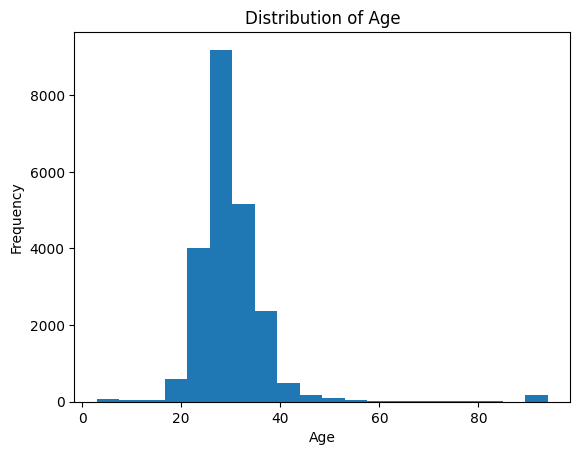

In [ ]:
# Create a histogram of the synopsis lengths

plt.hist(profiles_df_encoded['age'], bins=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.show()

### Save preprocessed df

In [ ]:
final_profiles_df = profiles_df_encoded.drop(columns=['favorites_anime', 'link', 'birthday'])

final_profiles_df.to_csv(f'{data_path}/raw_data/profiles_final.csv', index=False)
final_profiles_df.head(5)

,profile,favorites_anime_cleaned,Female,Male,Non-Binary,Unknown,birthday_epoch,age
0,DesolatePsyche,"[33352, 25013, 5530, 33674, 1482, 269, 18245, ...",0,1,0,0,781056000.0,30.0
1,baekbeans,"[11061, 31964, 853, 20583, 918, 9253, 34599, 3...",1,0,0,0,973814400.0,23.0
2,skrn,"[918, 2904, 11741, 17074, 23273, 32281, 9989, ...",0,0,0,1,NaN,NaN
3,edgewalker00,"[5680, 849, 2904, 3588, 37349]",0,1,0,0,NaN,NaN
4,aManOfCulture99,"[4181, 7791, 9617, 5680, 2167, 4382, 849, 235,...",0,1,0,0,941241600.0,24.0


# Reviews

In [ ]:
reviews_df = pd.read_csv(f'{data_path}/raw_data/reviews.csv')
reviews_df.head(5)

,uid,profile,anime_uid,text,score,scores,link
0,255938,DesolatePsyche,34096,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=255938
1,259117,baekbeans,34599,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=259117
2,253664,skrn,28891,\n \n \n \n ...,7,"{'Overall': '7', 'Story': '7', 'Animation': '9...",https://myanimelist.net/reviews.php?id=253664
3,8254,edgewalker00,2904,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '9...",https://myanimelist.net/reviews.php?id=8254
4,291149,aManOfCulture99,4181,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=291149


In [ ]:
reviews_df.columns

Index(['uid', 'profile', 'anime_uid', 'text', 'score', 'scores', 'link'], dtype='object')

### Preproces

In [ ]:
# Remove duplicated rows
print("Inital df length:", len(reviews_df))

duplicate_count = reviews_df.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)


reviews_df = reviews_df.drop_duplicates()
print("Remove duplicates df length:", len(reviews_df))

Inital df length: 192112
Number of duplicate rows: 61593
Remove duplicates df length: 130519


### Profiles

In [ ]:
reviews_profile_value_counts = reviews_df['profile'].value_counts()
reviews_profile_value_counts

Sidewinder51       611
Stark700           537
ktulu007           482
LegendAqua         442
ggultra2764        355
                  ... 
Natsu06              1
love_li-ren          1
swamped              1
kyashi39             1
srry4apologizng      1
Name: profile, Length: 47885, dtype: int64

In [ ]:
reviews_profile_value_counts.describe()

count    47885.000000
mean         2.725676
std          8.217880
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        611.000000
Name: profile, dtype: float64

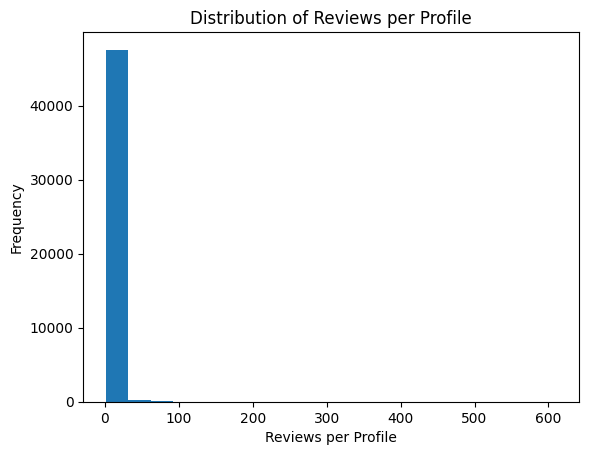

In [ ]:
plt.hist(reviews_profile_value_counts, bins=20)
plt.xlabel('Reviews per Profile')
plt.ylabel('Frequency')
plt.title('Distribution of Reviews per Profile')
plt.show()


### Anime Uid

In [ ]:
reviews_uid_value_counts = reviews_df['anime_uid'].value_counts().reset_index()
reviews_uid_value_counts.columns = ['uid', 'count']
reviews_uid_value_counts

,uid,count
0,11757,1292
1,1535,854
2,9253,779
3,32281,718
4,5114,637
...,...,...
8108,6609,1
8109,10043,1
8110,12663,1
8111,28257,1


In [ ]:
# the uid column here is actually the anime_uid

anime_titles = animes_df[['uid', 'title']]
reviews_counts = anime_titles.merge(reviews_uid_value_counts, on='uid')
reviews_counts.sort_values(by='count', ascending=False)

,uid,title,count
4962,11757,Sword Art Online,1292
711,1535,Death Note,854
743,9253,Steins;Gate,779
742,32281,Kimi no Na wa.,718
3,5114,Fullmetal Alchemist: Brotherhood,637
...,...,...,...
4882,2362,Run=Dim,1
6391,6229,Konpeki no Kantai,1
6392,2281,Jikuu Tantei Genshi-kun,1
6393,359,I'll/CKBC,1


In [ ]:
reviews_counts['count'].describe()

count    8113.000000
mean       16.087637
std        46.267327
min         1.000000
25%         1.000000
50%         3.000000
75%        11.000000
max      1292.000000
Name: count, dtype: float64

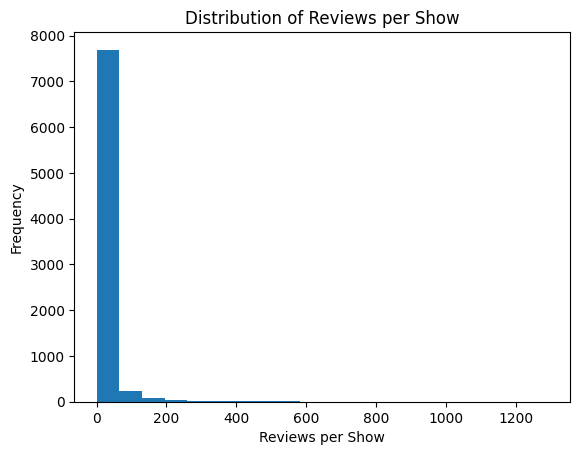

In [ ]:
plt.hist(reviews_counts['count'], bins=20)
plt.xlabel('Reviews per Show')
plt.ylabel('Frequency')
plt.title('Distribution of Reviews per Show')
plt.show()


### Text

In [ ]:
def clean_strings(lst):
    stripped_lst = [s.strip() for s in lst]
    stripped_lst = [s for s in stripped_lst if s != '']

    # Index of the start of the review
    index_to_filter = stripped_lst.index('Enjoyment') + 2

    # Remove Scores and 'Helpful' at the end
    filtered_lst = stripped_lst[index_to_filter:-1]

    cleaned_text = ' ' .join(filtered_lst)
    return cleaned_text


reviews_df['text'] = reviews_df['text'].str.replace('\r', '').str.split('\n').apply(clean_strings)

In [ ]:
text_len = reviews_df['text'].str.len()
text_len.describe()

count    130519.000000
mean       2729.374030
std        2724.929833
min          74.000000
25%        1019.000000
50%        1919.000000
75%        3482.000000
max       63403.000000
Name: text, dtype: float64

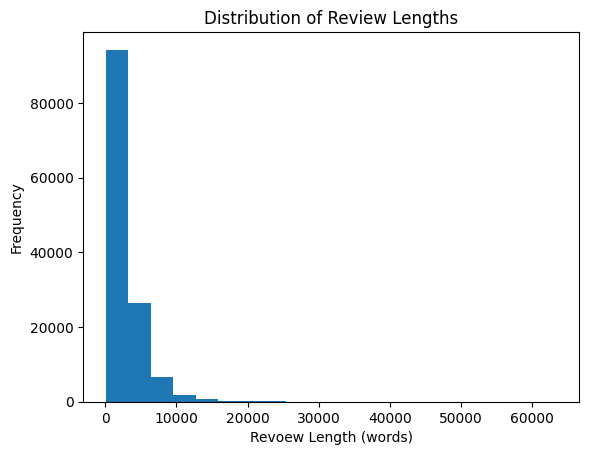

In [ ]:
# Create a histogram of the synopsis lengths

plt.hist(text_len, bins=20)
plt.xlabel('Revoew Length (words)')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.show()


### Score

In [ ]:
reviews_df['score'].describe()

count    130519.000000
mean          7.329737
std           2.321337
min           0.000000
25%           6.000000
50%           8.000000
75%           9.000000
max          11.000000
Name: score, dtype: float64

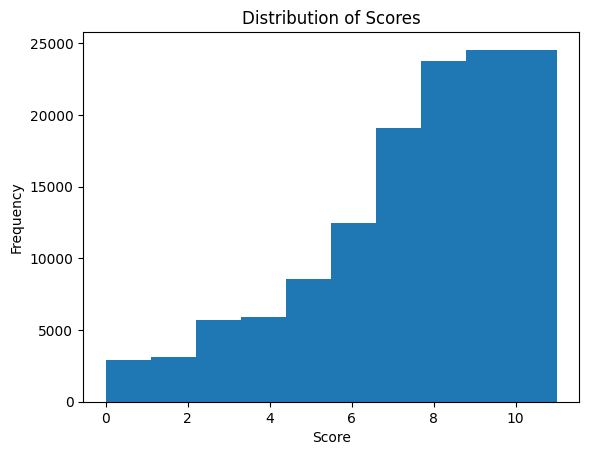

In [ ]:
# Create a histogram of the synopsis lengths

plt.hist(reviews_df['score'], bins=10)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')
plt.show()

### Scores

In [ ]:
reviews_df['eval_scores'] = reviews_df['scores'].apply(ast.literal_eval)

# Overall_score is same as score
# reviews_df['Overall_score'] = reviews_df['eval_scores'].apply(lambda x: x['Overall']).astype(int)
reviews_df['Story_score'] = reviews_df['eval_scores'].apply(lambda x: x['Story']).astype(int)
reviews_df['Animation_score'] = reviews_df['eval_scores'].apply(lambda x: x['Animation']).astype(int)
reviews_df['Sound_score'] = reviews_df['eval_scores'].apply(lambda x: x['Sound']).astype(int)
reviews_df['Character_score'] = reviews_df['eval_scores'].apply(lambda x: x['Character']).astype(int)
reviews_df['Enjoyment_score'] = reviews_df['eval_scores'].apply(lambda x: x['Enjoyment']).astype(int)


reviews_df.drop(columns=['eval_scores', 'scores'], inplace=True)

### Save preprocessed df

In [ ]:
final_reviews_df = reviews_df.drop(columns=['link'])

final_reviews_df.to_csv(f'{data_path}/raw_data/reviews_final.csv', index=False)
final_reviews_df.head(5)

,uid,profile,anime_uid,text,score,Story_score,Animation_score,Sound_score,Character_score,Enjoyment_score
0,255938,DesolatePsyche,34096,"First things first. My ""reviews"" system is exp...",8,8,8,10,9,8
1,259117,baekbeans,34599,Let me start off by saying that Made in Abyss ...,10,10,10,10,10,10
2,253664,skrn,28891,"Art 9/10: It is great, especially the actions ...",7,7,9,8,8,8
3,8254,edgewalker00,2904,Story taking place 1 yr from where season 1 tr...,9,9,9,10,10,9
4,291149,aManOfCulture99,4181,Kyoto Animations greatest strength is being ab...,10,10,8,9,10,10
